In [ ]:
!mkdir -p ~/.kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
fer2013.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/fer2013.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/sad/Training_65242339.jpg  
  inflating: /content/train/sad/Training_65267116.jpg  
  inflating: /content/train/sad/Training_65275626.jpg  
  inflating: /content/train/sad/Training_6529266.jpg  
  inflating: /content/train/sad/Training_65329617.jpg  
  inflating: /content/train/sad/Training_65338712.jpg  
  inflating: /content/train/sad/Training_65338797.jpg  
  inflating: /content/train/sad/Training_65387162.jpg  
  inflating: /content/train/sad/Training_65404494.jpg  
  inflating: /content/train/sad/Training_65426218.jpg  
  inflating: /content/train/sad/Training_65430136.jpg  
  inflating: /content/train/sad/Training_65437377.jpg  
  inflating: /content/train/sad/Training_6545735.jpg  
  inflating: /content/train/sad/Training_65463385.jpg  
  inflating: /content/train/sad/Training_65473985.jpg  
  inflating: /content/train/sad/Training_65502829.jpg  
  inflating: /content/train/sad/Training_65505359.jpg  

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import torch
from torch import nn
import random
import imghdr
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from PIL import Image
import seaborn as sns

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
dirs = ['fear', 'disgust', 'angry', 'happy', 'surprise', 'sad', 'neutral']
valid_files = ['jpg', 'jpeg', 'bmp', 'gif', 'png']

for dir in dirs:
  abs_path = os.path.join('train', dir)

  for img_path in os.listdir(abs_path):

    img_path = os.path.join(abs_path, img_path)
    try:

      file_type = imghdr.what(img_path)
      if file_type not in valid_files:
        os.remove(img_path)

    except Exception as e:
      print(f'Issue with file {img_path}. Error: {e}')
      os.remove(img_path)


for dir in dirs:
  abs_path = os.path.join('test', dir)

  for img_path in os.listdir(abs_path):

    img_path = os.path.join(abs_path, img_path)
    try:

      file_type = imghdr.what(img_path)
      if file_type not in valid_files:
        os.remove(img_path)

    except Exception as e:
      print(f'Issue with file {img_path}. Error: {e}')
      os.remove(img_path)

In [ ]:
train_count = {}
test_count = {}

for main_dir in ['train', 'test']:
  for dir in dirs:
    abs_path = os.path.join(main_dir, dir)
    if main_dir == 'train':
      train_count[dir] = len(os.listdir(abs_path))
    else:
      test_count[dir] = len(os.listdir(abs_path))

In [ ]:
train_count = dict(sorted(train_count.items(), key=lambda x : x[1]))
test_count = dict(sorted(test_count.items(), key=lambda x : x[1]))

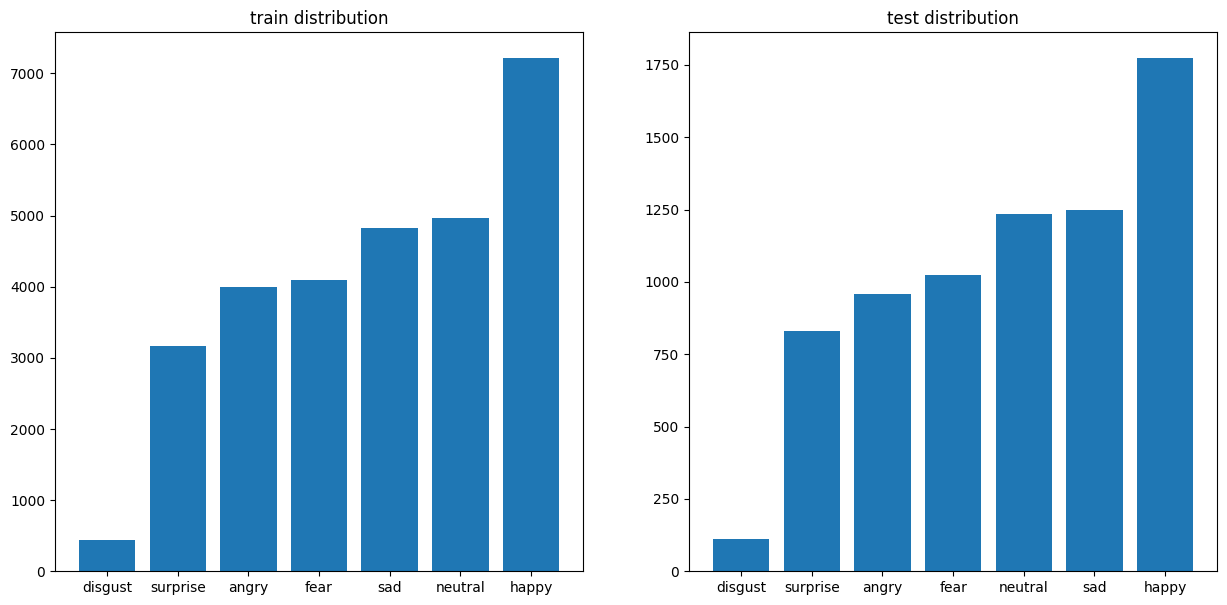

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

ax[0].bar(train_count.keys(), train_count.values())
ax[0].set_title('train distribution')

ax[1].bar(test_count.keys(), test_count.values())
ax[1].set_title('test distribution')

plt.show()

In [ ]:
def plot_images_from_directory(directory_path, class_name):

  image_filenames = os.listdir(directory_path)

  samples = random.sample(image_filenames, k=9)

  samples = [os.path.join(directory_path, sample) for sample in samples]

  fig, ax = plt.subplots(3,3, figsize=(15,10))
  ax = ax.ravel()

  for i in range(9):
    img = Image.open(samples[i]).convert('RGB')
    img = np.array(img)

    ax[i].imshow(img)
    ax[i].axis('off')

  plt.suptitle(class_name)
  plt.tight_layout()
  plt.show()

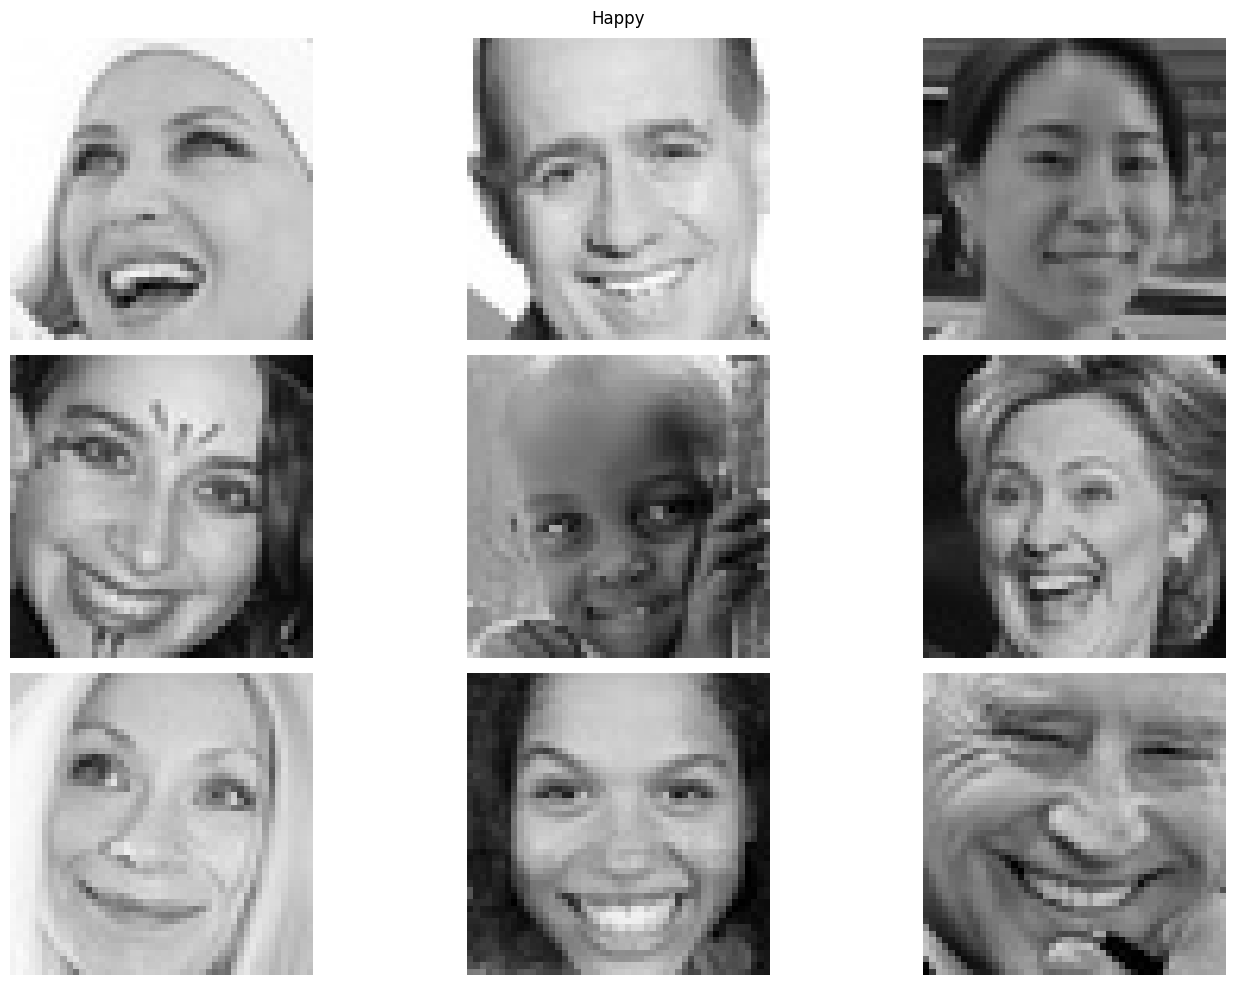

In [ ]:
plot_images_from_directory('train/happy', 'Happy')

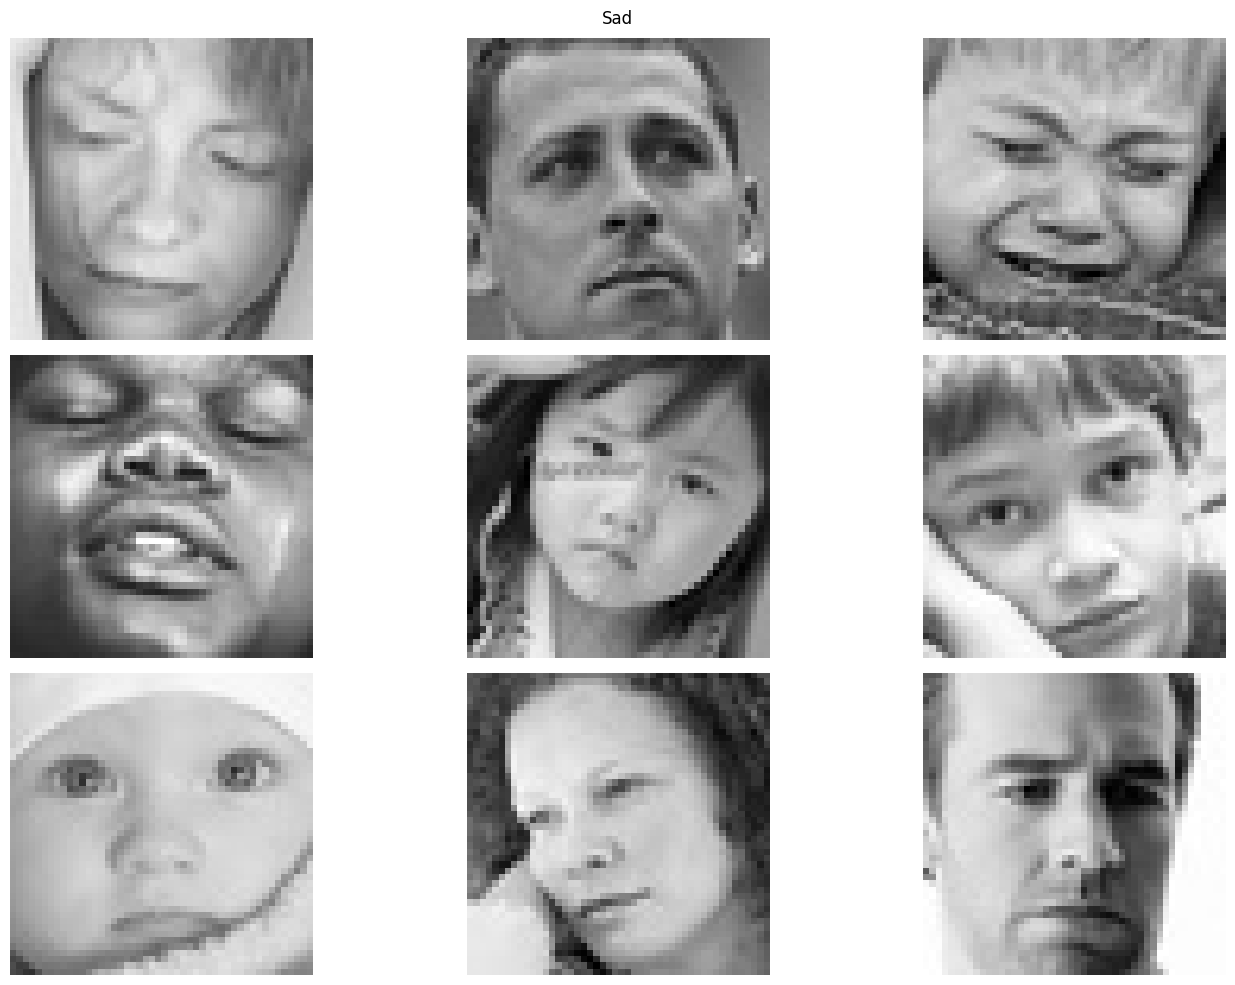

In [ ]:
plot_images_from_directory('train/sad', 'Sad')

In [ ]:
# combining the img list with abs path
# (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)

dirs = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

train_img_path = []
train_img_label = []

label_id = 0

for dir in dirs:
  abs_path = os.path.join('train', dir)
  imgs = [os.path.join(abs_path,img) for img in os.listdir(abs_path)]
  train_img_path.extend(imgs)
  label = [float(label_id)]*len(imgs)
  train_img_label.extend(label)
  label_id += 1

In [ ]:
# for test data too

dirs = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

test_img_path = []
test_img_label = []

label_id = 0

for dir in dirs:
  abs_path = os.path.join('test', dir)
  imgs = [os.path.join(abs_path,img) for img in os.listdir(abs_path)]
  test_img_path.extend(imgs)
  label = [float(label_id)]*len(imgs)
  test_img_label.extend(label)
  label_id += 1

In [ ]:
from collections import Counter

traincount = Counter(train_img_label)
testcount = Counter(test_img_label)

train_count, traincount , test_count, testcount

({'disgust': 436,
  'surprise': 3171,
  'angry': 3995,
  'fear': 4097,
  'sad': 4830,
  'neutral': 4965,
  'happy': 7215},
 Counter({0.0: 3995,
          1.0: 436,
          2.0: 4097,
          3.0: 7215,
          4.0: 4830,
          5.0: 3171,
          6.0: 4965}),
 {'disgust': 111,
  'surprise': 831,
  'angry': 958,
  'fear': 1024,
  'neutral': 1233,
  'sad': 1247,
  'happy': 1774},
 Counter({0.0: 958,
          1.0: 111,
          2.0: 1024,
          3.0: 1774,
          4.0: 1247,
          5.0: 831,
          6.0: 1233}))

In [ ]:
cnn_from_scratch_transform = transforms.Compose(
    [
        transforms.ToTensor()
    ]
)

In [ ]:
class CustomDataset(Dataset):

  def __init__(self, img_path_list, img_label_list, transform=None):
    self.img_path_list = img_path_list
    self.img_label_list = img_label_list
    self.transform = transform

  def __len__(self):
    return len(self.img_path_list)

  def __getitem__(self, idx):
    img, label = self.img_path_list[idx], self.img_label_list[idx]
    img = Image.open(img)

    if self.transform:
      img = self.transform(img)

    return img, label

In [ ]:
traindataset = CustomDataset(train_img_path, train_img_label, transform=cnn_from_scratch_transform)

In [ ]:
testdataset = CustomDataset(test_img_path, test_img_label, transform=cnn_from_scratch_transform)

In [ ]:
traindataloader = DataLoader(traindataset, batch_size=9, shuffle=True, num_workers=2, pin_memory=True)

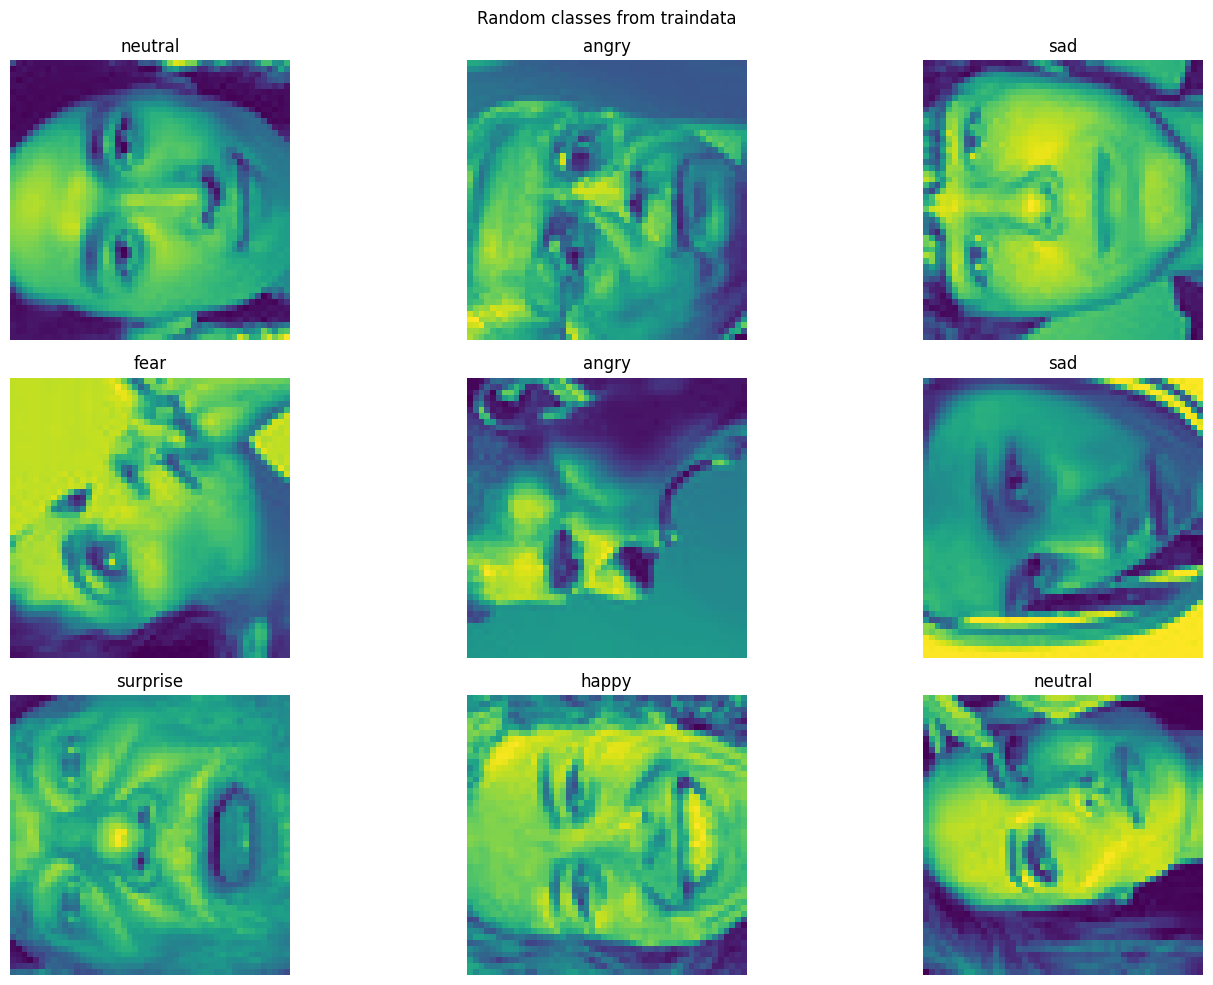

In [ ]:
label_mapper = {mapper[0]: mapper[1] for mapper in enumerate(dirs)}

for imgs, labels in traindataloader:

  fig, ax = plt.subplots(3,3, figsize=(15,10))
  ax = ax.ravel()

  for i in range(9):
    ax[i].imshow(imgs[i].T)
    ax[i].axis('off')
    label = labels[i].item()
    ax[i].set_title(label_mapper[label])

  plt.suptitle('Random classes from traindata')
  plt.tight_layout()
  plt.show()

  break

In [ ]:
class BasicCNN(nn.Module):
  def __init__(self):
    super().__init__()

    self.features = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding='same'),
        nn.BatchNorm2d(32),
        nn.ReLU(),

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same'),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=1),

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same'),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=1),
        nn.Dropout2d(0.4),
    )

    with torch.no_grad():
      dummy = torch.zeros(1,1,48,48)
      out = self.features(dummy).flatten().shape[0]

    self.classifier = nn.Sequential(
        nn.Flatten(),

        nn.Linear(out, 64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Dropout(0.3),

        nn.Linear(64, 7) # Removed nn.Sigmoid()
    )

  def forward(self, img_batch):
    out = self.features(img_batch)
    out = self.classifier(out)
    return out

In [ ]:
testdataloader = DataLoader(testdataset, batch_size=9, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
from ctypes.util import test
model = BasicCNN()
model = model.to(device)

loss_function = nn.CrossEntropyLoss() # Changed to CrossEntropyLoss

learning_rate = 0.01
epochs = 50

optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)


train_loss_per_epoch = []
test_loss_per_epoch = []

for epoch in range(epochs):
  epoch_train_loss = []
  epoch_test_loss = []

  model.train()

  for imgs, labels in traindataloader:
    imgs, labels = imgs.to(device), labels.to(device)
    pred = model(imgs) # pred are now logits

    loss = loss_function(pred, labels.long()) # Labels converted to long

    with torch.no_grad():
      epoch_train_loss.append(loss.item())

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  model.eval()

  with torch.no_grad():
    for imgs, labels in testdataloader:
      imgs, labels = imgs.to(device), labels.to(device)
      pred = model(imgs)
      loss = loss_function(pred, labels.long())
      epoch_test_loss.append(loss.item())


  current_train_loss = np.mean(np.array(epoch_train_loss))
  train_loss_per_epoch.append(current_train_loss)

  current_test_loss = np.mean(np.array(epoch_test_loss))
  test_loss_per_epoch.append(current_test_loss)
  print(f'at epoch {epoch} \n train loss is {current_train_loss} \n test loss is {current_test_loss}')

at epoch 0 
 train loss is 1.7030904611636852 
 test loss is 1.4845085955203925
at epoch 1 
 train loss is 1.5395946446444173 
 test loss is 1.4610897846389235
at epoch 2 
 train loss is 1.4794575750454093 
 test loss is 1.3614869284301174
at epoch 3 
 train loss is 1.4292752616831501 
 test loss is 1.321446797303986
at epoch 4 
 train loss is 1.4046992204406046 
 test loss is 1.3217607887839913
at epoch 5 
 train loss is 1.370433435283111 
 test loss is 1.289796114341358
at epoch 6 
 train loss is 1.3444118693704517 
 test loss is 1.2570893439956774
at epoch 7 
 train loss is 1.3206726342719923 
 test loss is 1.2507746686463368
at epoch 8 
 train loss is 1.29430393989557 
 test loss is 1.266798901901508
at epoch 9 
 train loss is 1.2722682669244965 
 test loss is 1.2631990228380476
at epoch 10 
 train loss is 1.2479656661192078 
 test loss is 1.2065066637700064
at epoch 11 
 train loss is 1.2208196921408363 
 test loss is 1.2091736649734932
at epoch 12 
 train loss is 1.19893478349458

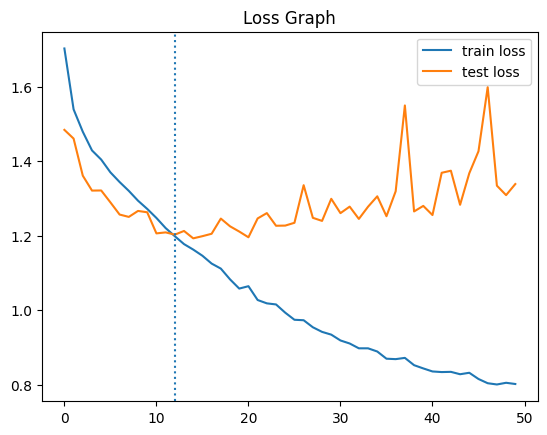

In [ ]:
plt.plot(train_loss_per_epoch, label='train loss')
plt.plot(test_loss_per_epoch, label='test loss')
plt.axvline(x=12, linestyle ='dotted')
plt.legend()
plt.title('Loss Graph')
plt.show()

In [ ]:
model.eval()


all_predictions = []
all_targets = []

with torch.no_grad():
  for imgs, labels in testdataloader:
    imgs, labels = imgs.to(device), labels.to(device)
    outputs = model(imgs)
    outputs = outputs.argmax(dim=1)
    all_predictions.extend(outputs.cpu().numpy())
    all_targets.extend(labels.cpu().numpy())


print('accuracy_scoree on test data : ', accuracy_score(all_targets, all_predictions))

accuracy_scoree on test data :  0.564641961549178


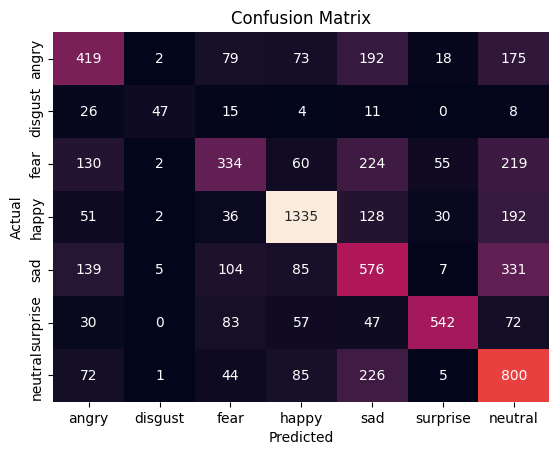

In [ ]:
mtx = confusion_matrix(all_targets, all_predictions)

sns.heatmap(mtx, annot=True, fmt='d', cbar=False, xticklabels=dirs, yticklabels=dirs)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
torch.save(model, '/content/Emotion-Detection-Project/content/Custom_CNN_from_scratch/BasicCNN.pth')